# Fashion MNIST Classification

## Import the necessary libraries

In [7]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

## Load the Fashion MNIST dataset:
- split into train, test and validation
- normalize and transform the images to tensors

In [8]:
train_set = datasets.FashionMNIST("", train=True, download=True,
                                  transform=transforms.Compose([transforms.ToTensor()]))
test_set = datasets.FashionMNIST("", train=False, download=True,
                                 transform=transforms.Compose([transforms.ToTensor()]))

# split the train_set dataset into train_set and validation
train_set, val = torch.utils.data.random_split(train_set, [50000, 10000])

### Check the length of the train, test and validation datasets

In [9]:
len(train_set), len(test_set), len(val)

(50000, 10000, 10000)

## Show some images from the dataset

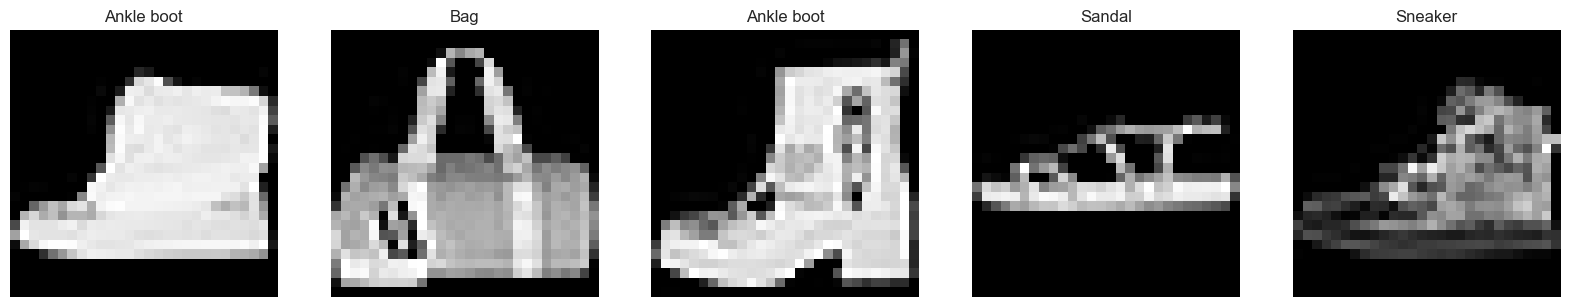

In [10]:
import matplotlib.pyplot as plt
num_figures = 5

idx_to_class = {v: k for k, v in test_set.class_to_idx.items()}
fig, axs = plt.subplots(1, num_figures, figsize=(20, 5))
for i in range(num_figures):
    axs[i].imshow(train_set[i][0].reshape(28, 28), cmap='gray')
    axs[i].set_title(idx_to_class[train_set[i][1]])
    axs[i].axis('off')
plt.show()

## Create a simple neural network model

In [11]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
        # Apply the weight initialization method during initialization
        self.apply(self.init_weights)

    # Define the weight initialization method within the class
    def init_weights(self, m) -> None:
        if isinstance(m, nn.Linear):
            if m == self.fc3:  # Last layer has no ReLU, so no special nonlinearity
                init.xavier_uniform_(m.weight)  # Xavier for the final layer
            else:
                init.kaiming_normal_(m.weight, nonlinearity='relu')  # He initialization for layers with ReLU
            if m.bias is not None:
                init.constant_(m.bias, 0)  # Initialize biases to 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.shape[0], -1) # flatten the input tensor

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)

        return x

## Create model, dataloaders, loss function and optimizer

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use gpu if available
print(f"Using {device}")

cls = Classifier()
cls.to(device)

# create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=True)

# define cross entropy loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cls.parameters(), lr=0.001)

Using cuda


## Define a function to validate the model

In [13]:
def validate(model: nn.Module, dataloader: DataLoader) -> tuple[float, float]:
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).sum().item()
            total += y.size(0)
    return loss/len(dataloader), correct/total

## Log metrics to wandb

- use wandb, a tool for experiment tracking, to log metrics
- wandb.init() initializes the wandb run
- wandb.watch() watches the model allowing wandb to log gradients and parameters
- log_metrics() logs the metrics to wandb


In [15]:
from collections.abc import Mapping
import wandb

wandb.init(project='fashion-mnist-classification', name='baseline_init')
wandb.watch(cls)

def log_metrics(metrics: Mapping) -> None:
    """
    Logs the given metrics to Weights and Biases (wandb).

    Args:
        metrics (Mapping): A dictionary-like object containing key-value pairs, 
                           where the keys are metric names (as strings) and the values 
                           are the corresponding metric values (numbers).

    Returns:
        None
    """
    wandb.log(metrics)

## Train the model

In [ ]:
from tqdm import tqdm
from typing import Callable, Iterable, Tuple
import torch
from torch import nn
from torch.optim import Optimizer

def train_one_epoch(model: nn.Module, 
                    data_loader: Iterable[Tuple[torch.Tensor, torch.Tensor]], 
                    loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], 
                    optimizer: Optimizer) -> Tuple[float, int]:
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The neural network model to train.
        data_loader (Iterable[Tuple[torch.Tensor, torch.Tensor]]): An iterable that yields batches of input tensors (X) and target tensors (y).
        loss_fn (Callable[[torch.Tensor, torch.Tensor], torch.Tensor]): Loss function to compute the difference between the predictions and true labels.
        optimizer (Optimizer): Optimizer to update the model's weights.

    Returns:
        Tuple[float, int]: The total loss and the number of correctly classified examples during this epoch.
    """
    total_loss, train_acc = 0, 0

    for X, y in data_loader:
        # Move the data to the device (GPU if available)
        X, y = X.to(device), y.to(device)
        # Forward pass
        y_pred = model(X)
        # Compute the loss
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()
        
        # Backward pass
        # Zero the gradients before backpropagation
        optimizer.zero_grad()
        # Compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()
        
        # Compute the number of correctly classified examples
        train_acc += (y_pred.argmax(1) == y).sum().item()

    return total_loss, train_acc


def train(model: nn.Module, 
          train_dataloader: Sized &  Iterable[Tuple[torch.Tensor, torch.Tensor]], 
          val_dataloader: Sized &  Iterable[Tuple[torch.Tensor, torch.Tensor]], 
          loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], 
          optimizer: Optimizer, 
          epochs: int = 10) -> None:
    """
    Trains the model for a specified number of epochs, and evaluates on validation data.

    Args:
        model (nn.Module): The neural network model to train.
        train_dataloader (Iterable[Tuple[torch.Tensor, torch.Tensor]]): An iterable that yields batches of input tensors (X) and target tensors (y) for training.
        val_dataloader (Iterable[Tuple[torch.Tensor, torch.Tensor]]): An iterable that yields batches of input tensors (X) and target tensors (y) for validation.
        loss_fn (Callable[[torch.Tensor, torch.Tensor], torch.Tensor]): Loss function to compute the difference between the predictions and true labels.
        optimizer (Optimizer): Optimizer to update the model's weights.
        epochs (int, optional): Number of training epochs. Defaults to 10.

    Returns:
        None
    """
    
    # Iterate over the specified number of epochs using tqdm for progress bar
    with tqdm(range(epochs)) as pbar:
        for epoch in pbar:
            # Train one epoch
            total_loss, train_acc = train_one_epoch(model, train_dataloader, loss_fn, optimizer)
            
            # Compute average training loss and accuracy
            train_acc /= len(train_dataloader)
            train_loss = total_loss / len(train_dataloader)
            
            # Validate model loss and accuracy on the validation set
            val_loss, val_acc = validate(model, val_dataloader)
            
            # Log training and validation metrics
            metrics: Dict[str, float] = {
                'train_loss': train_loss, 
                'train_acc': train_acc, 
                'val_loss': val_loss, 
                'val_acc': val_acc
            }
            log_metrics(metrics)

            # Update progress bar with current metrics
            metrics.update({'epoch': epoch + 1})
            pbar.set_postfix(metrics)

In [17]:
# train the model
epochs = 10
train(cls, train_dataloader, val_dataloader, loss_fn, optimizer, epochs)

100%|██████████| 10/10 [01:24<00:00,  8.41s/it, train_loss=0.248, train_acc=90.8, val_loss=0.288, val_acc=0.896, epoch=10]


## Evaluate the model on the test dataset

In [18]:
# evaluate the model
test_loss, test_acc = validate(cls, test_dataloader)
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

Test loss: 0.3248372320830822, Test accuracy: 0.8851


## Visualize the model predictions

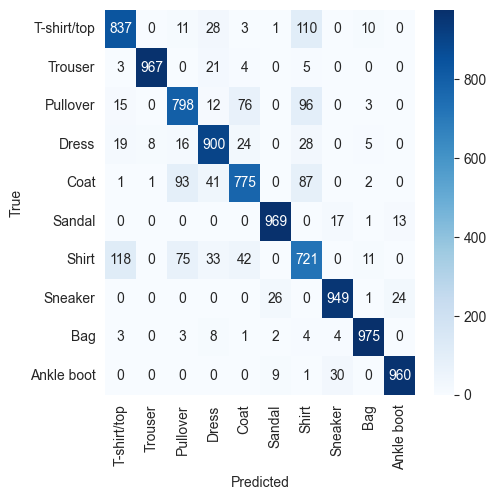

In [19]:
# visualize the model predictions
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(cls(X).argmax(1).cpu().numpy())
        
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_set.classes, yticklabels=test_set.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.show()

plt.savefig('confusion_matrix.png')

## Show some images with their correct and predicted labels

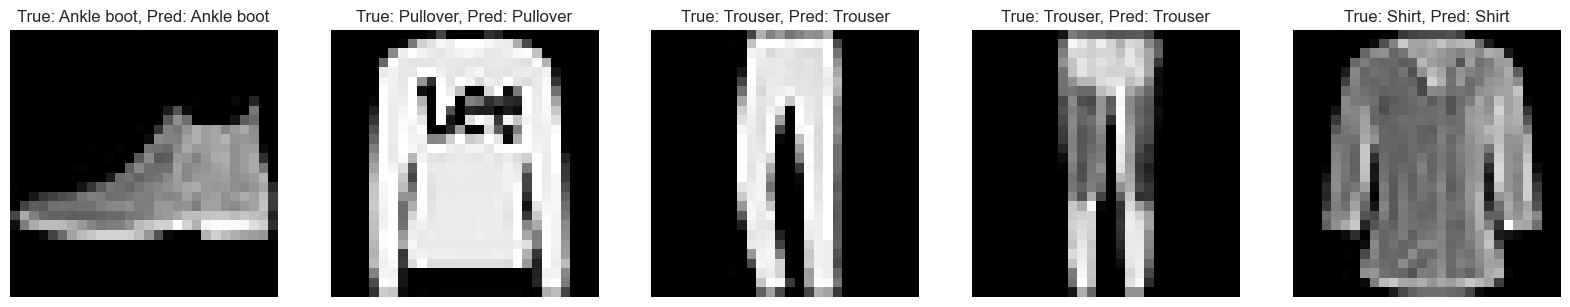

In [20]:
# show fw predictions wth correct labels and predicted labels
fig, axs = plt.subplots(1, num_figures, figsize=(20, 5))

with torch.no_grad():
    for i in range(5):
        X, y = test_set[i]
        X = X.to(device)
        pred = cls(X.unsqueeze(0)).argmax(1).item()
        axs[i].imshow(X.reshape(28, 28).cpu(), cmap='gray')
        axs[i].set_title(f"True: {idx_to_class[y]}, Pred: {idx_to_class[pred]}")
        axs[i].axis('off')
plt.show()

## Show some misclassified images

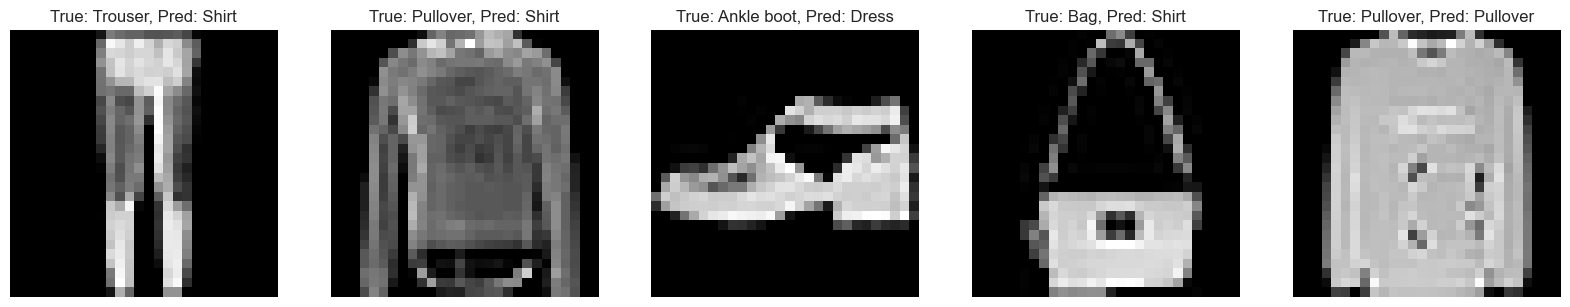

In [21]:
fig, axs = plt.subplots(1, num_figures, figsize=(20, 5))

missclassfied_idx = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
missclassfied_examples = torch.utils.data.Subset(test_set, missclassfied_idx)
from itertools import islice

for i, (X, y) in enumerate(islice(missclassfied_examples, 5)):
    axs[i].imshow(X.reshape(28, 28), cmap='gray')
    axs[i].set_title(f"True: {idx_to_class[y]}, Pred: {idx_to_class[y_pred[missclassfied_idx[i]]]}")
    axs[i].axis('off')
plt.show()